# Introduction

This notebook demonstrates hybrid cnn with one layer of quantum for binary classification problem using eurosat dataset.

# Runtime req

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q torch
!pip install -q matplotlib
!pip install -q visualkeras
!pip install -q qiskit
!pip install pylatexenc

!unzip -q "/content/drive/MyDrive/colab_notebooks/IITD-QML/EuroSAT_RGB.zip"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 13.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [236]:
import qiskit
import sys
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import random
import time

import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

from qiskit import *
provider = qiskit
backend = Aer.get_backend("aer_simulator", device="GPU")


<module 'qiskit' from '/usr/local/lib/python3.10/dist-packages/qiskit/__init__.py'> aer_simulator


## GPU and CPU detection choice

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataset handling for loading, splitting, training.

The following section has the utilities required for operating with the data.
- Detect list of classes from the dataset root directory provided ( inside the constructor )
- Load path labels, ( image paths and labels per class ) and shuffle the data set to generate randomness.
- Provide a generator which can be provided into the torch circuit with random data set selection insde the training or test data set.



In [186]:
import glob
import os
import numpy as np
import random

class DatasetHandler:
    def __init__(self, ds_root_path):
        print ('Datahandler init -> ', ds_root_path)
        self.dataset_path = ds_root_path
        self.classes = glob.glob(os.path.join(ds_root_path, '*'))
        self.classes_dict = {}
        for c, i in zip(self.classes, range(len(self.classes))):
          self.classes_dict[c] = i

    def print_classes(self):
        print('Classes in the path: ')
        for i,c in enumerate(self.classes):
            print(i, ' ->', c)

    def load_paths_labels(self, root, classes):
        imgs_path = []
        imgs_label = []

        for clss in classes:
            for path in glob.glob(os.path.join(root, clss+'/*')):
              imgs_path.append(path)
              imgs_label.append(self.classes_dict[clss])

        dataset = list(zip(imgs_path, imgs_label))
        random.shuffle(dataset)
        paths, labels = zip(*dataset)
        return np.array(paths), np.array(labels)

    # Split the dataset into training and validation dataset
    def train_validation_split(self, images, labels, split_factor = 0.2):
        val_size = int(len(images)*split_factor)
        train_size = int(len(images) - val_size)
        return images[0:train_size], labels[0:train_size, ...], images[train_size:train_size+val_size], labels[train_size:train_size+val_size, ...]

    # Data genertor: given images paths and images labels yield a batch of images and labels
    def cnn_data_loader(self, imgs_path, imgs_label, batch_size = 1, img_shape = (64, 64, 3), n_classes = 2):
      # Initialize the vectors to be yield
      batch_in = np.zeros((batch_size, img_shape[2], img_shape[0], img_shape[1]))
      batch_out = np.zeros((batch_size))
      random.seed(time.time())

      while True:
        for i in range(batch_size):
          index = random.randint(0, len(imgs_path)-1)
          batch_in[i, ...] = np.transpose(plt.imread(imgs_path[index])/255.0)
          batch_out[i] = imgs_label[index]
          yield  torch.tensor(batch_in).type(torch.float).to(device),  torch.tensor(batch_out).type(torch.float).to(device)



In [6]:
sys.path.append('/content/drive/MyDrive/colab_notebooks/IITD-QML/')
dataset_root_path = '/content/EuroSAT_RGB'


In [187]:
handler = DatasetHandler(dataset_root_path)
imgs_path, imgs_label = handler.load_paths_labels(dataset_root_path, handler.classes[:2])
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])

Datahandler init ->  /content/EuroSAT_RGB
Dataset images: 5000 Dataset labels: 5000
Dataset sample -> /content/EuroSAT_RGB/Highway/Highway_663.jpg 0


In [188]:
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)
print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape)

X_train shape: (4000,) Y_train shape: (4000,)
  X_val shape:  (1000,)   Y_val shape:  (1000,)


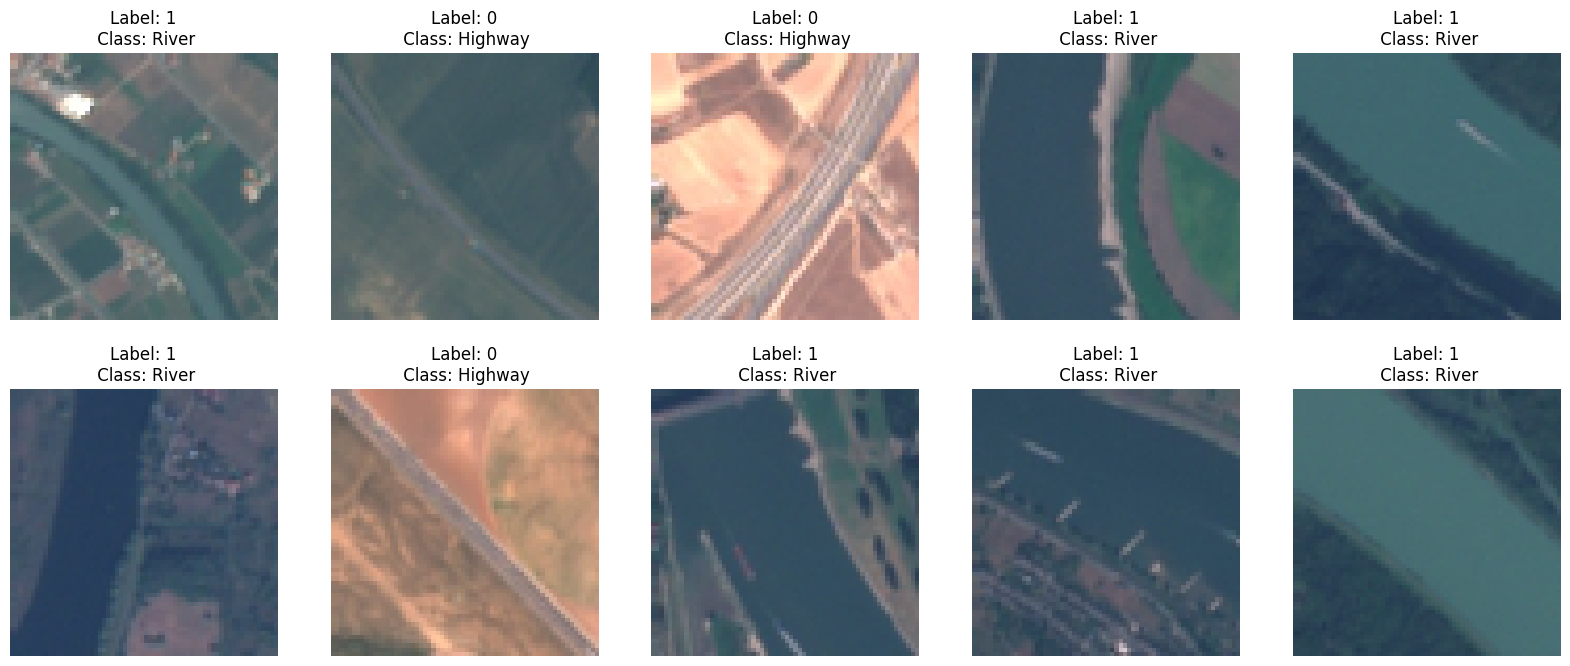

In [9]:
def plotDataset(images, labels, classes, columns, rows):
    fig, axes = plt.subplots(nrows = rows, ncols = columns, figsize = (columns*4,rows*4))
    for x in range(columns):
        for y in range(rows):
            index = random.randint(0, len(images)-1)

            axes[y,x].imshow(plt.imread(images[index]))
            axes[y,x].set_title('Label: ' + str(labels[index]) +
                                '\n Class: ' + classes[labels[index]].split('/')[-1])
            axes[y,x].axis(False)

    plt.show()
plotDataset(train_imgs, train_labels, handler.classes[:2], columns = 5, rows = 2)

# Classical binary classification CNN

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)

        self.fc1 = nn.Linear(2304, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 42)
        self.fc4 = nn.Linear(42, 16)
        self.fc5 = nn.Linear(16, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))

        x = x.view(-1, 2304)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))

        x = F.relu(self.fc3(x))

        x = self.fc4(x)
        x = np.pi*torch.tanh(x)
        x = self.fc5(x.float())
        x = F.softmax(x, 1)

        return x


    def predict(self, x):
        pred = self.forward(x)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)

network = Net().to(device)
optimizer = optim.Adam(network.parameters(), lr=0.0002)

In [11]:
from torchsummary import summary
summary(network, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
            Conv2d-2           [-1, 32, 29, 29]           4,640
            Conv2d-3           [-1, 64, 12, 12]          18,496
            Linear-4                  [-1, 120]         276,600
            Linear-5                   [-1, 84]          10,164
            Linear-6                   [-1, 42]           3,570
            Linear-7                   [-1, 16]             688
            Linear-8                    [-1, 2]              34
Total params: 314,640
Trainable params: 314,640
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.75
Params size (MB): 1.20
Estimated Total Size (MB): 1.99
----------------------------------------------------------------


In [12]:
train_loss_list = []
val_loss_list = []
epochs = 20

loss_func = nn.CrossEntropyLoss()

for epoch in range(epochs):
  dataset = list(zip(train_imgs, train_labels))
  random.shuffle(dataset)
  train_imgs, train_labels = zip(*dataset)
  train_loader = iter(handler.cnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
  test_loader = iter(handler.cnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
  total_loss = []
  for batch_idx in range(len(train_labels)):
    data, target = next(train_loader)
    # print(batch_idx)
    optimizer.zero_grad()
    # Forward pass
    output = network(data)
    target = target.type(torch.LongTensor).to(device)
    # Calculating loss
    loss = loss_func(output, target)
    # Backward pass
    loss.backward()
    # Optimize the weights
    optimizer.step()

    total_loss.append(loss.item())

    print('\r Epoch %d ~ Batch %d (%d) ~ Loss %f ' % (epoch, batch_idx, len(train_imgs)-1, loss.item()), end='\t\t')


  with torch.no_grad():
    val_loss = []
    targets = []
    predictions = []
    for batch_idx in range(len(val_images)):
      data, target = next(test_loader)
      output = network(data)
      target = target.type(torch.LongTensor).to(device)

      loss = loss_func(output, target)
      val_loss.append(loss.item())

      targets.append(target.item())

      predictions.append(network.predict(data).item())


    train_loss_list.append(sum(total_loss)/len(total_loss))
    val_loss_list.append(sum(val_loss)/len(val_loss))

    print('Training [{:.0f}%]\t Training Loss: {:.4f} Validation Loss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, train_loss_list[-1], val_loss_list[-1]))

    print(confusion_matrix(targets, predictions,normalize='true'))
    print(classification_report(targets, predictions, target_names=handler.classes[:2], digits=4))

    torch.save({
            'epoch': epoch,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss_list[-1],
            }, '/content/drive/MyDrive/colab_notebooks/IITD-QML/model-classical.pt')


 Epoch 0 ~ Batch 3999 (3999) ~ Loss 0.316987 		Training [5%]	 Training Loss: 0.6400 Validation Loss: 0.5728
[[0.66859345 0.33140655]
 [0.1975052  0.8024948 ]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.7851    0.6686    0.7222       519
  /content/EuroSAT_RGB/River     0.6918    0.8025    0.7430       481

                    accuracy                         0.7330      1000
                   macro avg     0.7384    0.7355    0.7326      1000
                weighted avg     0.7402    0.7330    0.7322      1000

 Epoch 1 ~ Batch 3999 (3999) ~ Loss 0.322361 		Training [10%]	 Training Loss: 0.5779 Validation Loss: 0.5780
[[0.61153846 0.38846154]
 [0.17291667 0.82708333]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.7930    0.6115    0.6906       520
  /content/EuroSAT_RGB/River     0.6628    0.8271    0.7359       480

                    accuracy                  

In [13]:
torch.save(network.state_dict(), '/content/drive/MyDrive/colab_notebooks/IITD-QML/model-classical.pt')

In [14]:
test_loader = iter(handler.cnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
accuracy = 0
number = 0

predictions = []
targets = []

for ct in range(len(val_images)):

  data, target = next(test_loader)
  number +=1
  output = network.predict(data).item()

  predictions.append(output)
  targets.append(target.item())

  accuracy += (output == target[0].item())*1
  print('\r ' + str(ct), end='')

 999

(array([513.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 487.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

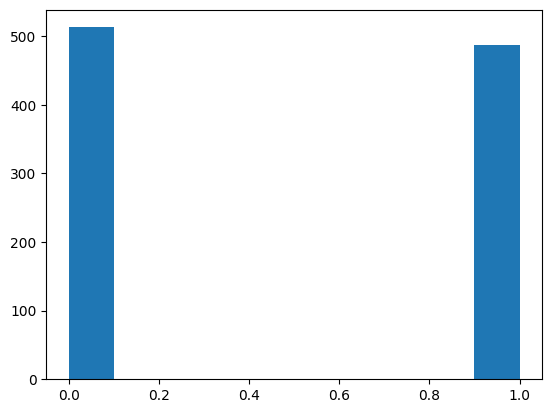

In [15]:
plt.hist(targets, bins = 10)

In [16]:
print("Performance on test data is : {}/{} = {}%".format(accuracy,number,100*accuracy/number))

Performance on test data is : 880/1000 = 88.0%


In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(targets, predictions,normalize='true')

S2
Accuracy: [0.95711501 0.79876797] mean:  0.8779414884461896
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.8336    0.9571    0.8911       513
  /content/EuroSAT_RGB/River     0.9465    0.7988    0.8664       487

                    accuracy                         0.8800      1000
                   macro avg     0.8900    0.8779    0.8787      1000
                weighted avg     0.8886    0.8800    0.8791      1000



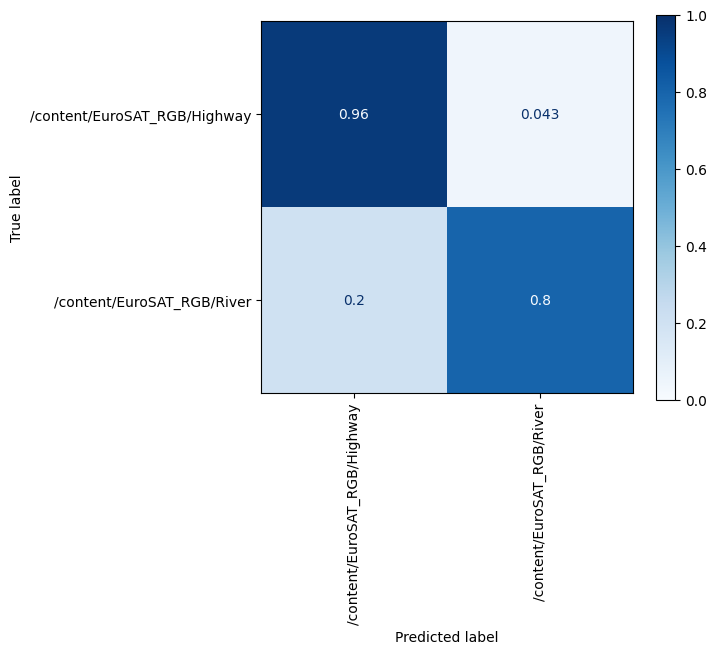

In [18]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))

cmd = ConfusionMatrixDisplay(cm, display_labels=handler.classes[:2])
cmd.plot(ax=axes, cmap='Blues', xticks_rotation='vertical')
print('S2')
print('Accuracy:', cm.diagonal(), 'mean: ', cm.diagonal().mean())
print(classification_report(targets, predictions, target_names=handler.classes[:2], digits=4))
axes.get_images()[0].set_clim(0, 1)
plt.show()
plt.close()

In [19]:
!pip install torchview

# Quantum classification layer.

In [148]:
NUM_QUBITS = 4
NUM_SHOTS = 1500
SHIFT = np.pi/4
LEARNING_RATE = 0.0002
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('aer_simulator')

## Quantum circuit to be embedded into the layer.

The following circuit code below, generates a bell circuit of 4 Qubits for usage in the CNN down under.
4 Qubit circuit generates, 16 states which can be used as inputs to the state next.
The previous layer in quantum has 4 as outputs which are connected to the QC circuit as inputs.

In [21]:
import itertools
def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


In [237]:
class QCNeuron():
    def __init__(self, n_qubits, backend, shots):
        self.qc = QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.thetas = {k : Parameter('Theta'+str(k)) for k in range(self.n_qubits)}

        self.qc.h(0)
        self.qc.cx(1, 0)
        self.qc.cx(2, 1)
        self.qc.cx(3, 2)

        self.qc.barrier()

        for k in range(0, 4):
            self.qc.ry(self.thetas[k], k)

        self.qc.barrier()

        self.qc.cx(3, 2)
        self.qc.cx(2, 1)
        self.qc.cx(1, 0)
        self.qc.h(0)

        self.qc.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots

        self.tqc = transpile(self.qc, backend=self.backend)


    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0)/shots
            expects[k] = perc
        return expects

    def run(self, i):
        params = i.cpu().data.numpy()
        parameters = {}

        for k in range(self.n_qubits):
          parameters[self.thetas[k]] = params[k].item()

        qobj = assemble(self.tqc,
                        shots=self.shots,
                        parameter_binds = [parameters])

        job = self.backend.run(qobj)
        res =  self.N_qubit_expectation_Z(job.result().get_counts(), self.shots, self.n_qubits)
        return res

## Sample QC circuit with 4 parameters is below.

In [233]:
circuit = QCNeuron(NUM_QUBITS, Aer.get_backend('aer_simulator', device="GPU"), NUM_SHOTS)
circuit.qc.draw(fold=2000)

┌───┐┌───┐           ░ ┌────────────┐ ░           ┌───┐┌───┐ ░ ┌─┐         
   q_0: ┤ H ├┤ X ├───────────░─┤ Ry(Theta0) ├─░───────────┤ X ├┤ H ├─░─┤M├─────────
        └───┘└─┬─┘┌───┐      ░ ├────────────┤ ░      ┌───┐└─┬─┘└───┘ ░ └╥┘┌─┐      
   q_1: ───────■──┤ X ├──────░─┤ Ry(Theta1) ├─░──────┤ X ├──■────────░──╫─┤M├──────
                  └─┬─┘┌───┐ ░ ├────────────┤ ░ ┌───┐└─┬─┘           ░  ║ └╥┘┌─┐   
   q_2: ────────────■──┤ X ├─░─┤ Ry(Theta2) ├─░─┤ X ├──■─────────────░──╫──╫─┤M├───
                       └─┬─┘ ░ ├────────────┤ ░ └─┬─┘                ░  ║  ║ └╥┘┌─┐
   q_3: ─────────────────■───░─┤ Ry(Theta3) ├─░───■──────────────────░──╫──╫──╫─┤M├
                             ░ └────────────┘ ░                      ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                        0  1  2  3

In [234]:
np_array = np.array([5, 7, 1, 2])

# Convert Numpy array to torch.Tensor
tensor_a = torch.from_numpy(np_array)

circuit.run(tensor_a)

<ipython-input-230-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


array([0.12933333, 0.062     , 0.01666667, 0.01      , 0.00466667,
       0.00133333, 0.04266667, 0.01933333, 0.09666667, 0.04866667,
       0.014     , 0.00466667, 0.03866667, 0.024     , 0.32866667,
       0.15866667])

## Quantum neural network hidden layer

In [238]:
class QuantumLayer(Function):
    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'qc'):
            ctx.qc = QCNeuron(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)

        exp_value = ctx.qc.run(i)
        result = torch.tensor([exp_value]).to(device)
        ctx.save_for_backward(result, i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        forward_tensor, i = ctx.saved_tensors
        input_numbers = i
        gradients = torch.Tensor()

        for k in range(NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT

            expectation_right = ctx.qc.run(shift_right)
            expectation_left  = ctx.qc.run(shift_left)

            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients = torch.cat((gradients, gradient.float()))

        result = torch.Tensor(gradients).to(device)

        return (result.float() * grad_output.float()).T

In [241]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(2304, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 42)
        self.fc4 = nn.Linear(42, 4)
        self.qc = QuantumLayer.apply
        self.fc5 = nn.Linear(16, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))

        x = x.view(-1, 2304)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))

        x = F.relu(self.fc3(x))

        x = self.fc4(x)
        x = np.pi*torch.tanh(x)

        x = self.qc(x[0]) # QUANTUM LAYER
        x = F.relu(x)

        x = self.fc5(x.float())
        x = F.softmax(x, 1)
        return x


    def predict(self, x):
        # apply softmax
        pred = self.forward(x)
#         print(pred)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)

hybrid_network = Net().to(device)
optimizer = optim.Adam(hybrid_network.parameters(), lr=0.0002)

In [155]:
summary(hybrid_network, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
            Conv2d-2           [-1, 32, 29, 29]           4,640
            Conv2d-3           [-1, 64, 12, 12]          18,496
            Linear-4                  [-1, 120]         276,600
            Linear-5                   [-1, 84]          10,164
            Linear-6                   [-1, 42]           3,570
            Linear-7                    [-1, 4]             172
            Linear-8                    [-1, 2]              34
Total params: 314,124
Trainable params: 314,124
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.75
Params size (MB): 1.20
Estimated Total Size (MB): 1.99
----------------------------------------------------------------


<ipython-input-149-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


In [243]:
train_loss_list = []
val_loss_list = []
epochs = 50

loss_func = nn.CrossEntropyLoss()

for epoch in range(epochs):
  train_loader = iter(handler.cnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
  test_loader = iter(handler.cnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
  total_loss = []
  for batch_idx in range(len(train_labels)):
    data, target = next(train_loader)
    # print(batch_idx)
    optimizer.zero_grad()
    # Forward pass
    output = hybrid_network(data)
    target = target.type(torch.LongTensor).to(device)
    # Calculating loss
    loss = loss_func(output, target)
    # Backward pass
    loss.backward()
    # Optimize the weights
    optimizer.step()

    total_loss.append(loss.item())

    print('\rEpoch %d ~ Batch %d (%d) ~ Loss %f ' % (epoch, batch_idx, len(train_imgs)-1, loss.item()), end='\t\t')


  with torch.no_grad():
    val_loss = []
    targets = []
    predictions = []
    for batch_idx in range(len(val_images)):
      data, target = next(test_loader)
      output = hybrid_network(data)
      target = target.type(torch.LongTensor).to(device)

      loss = loss_func(output, target)
      val_loss.append(loss.item())

      targets.append(target.item())

      predictions.append(hybrid_network.predict(data).item())


    train_loss_list.append(sum(total_loss)/len(total_loss))
    val_loss_list.append(sum(val_loss)/len(val_loss))

    print('Training [{:.0f}%]\t Training Loss: {:.4f} Validation Loss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, train_loss_list[-1], val_loss_list[-1]))

    print(confusion_matrix(targets, predictions,normalize='true'))
    print(classification_report(targets, predictions, target_names=handler.classes[:2], digits=4, labels=np.unique(predictions)))

    torch.save({
            'epoch': epoch,
            'model_state_dict': hybrid_network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss_list[-1],
            }, '/content/drive/MyDrive/colab_notebooks/IITD-QML/model-hybrid-binary-classification.pt')


<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 0 ~ Batch 3999 (3999) ~ Loss 0.744893 		Training [2%]	 Training Loss: 0.5955 Validation Loss: 0.5611
[[0.77099237 0.22900763]
 [0.23109244 0.76890756]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.7860    0.7710    0.7784       524
  /content/EuroSAT_RGB/River     0.7531    0.7689    0.7609       476

                    accuracy                         0.7700      1000
                   macro avg     0.7695    0.7699    0.7697      1000
                weighted avg     0.7703    0.7700    0.7701      1000

Epoch 1 ~ Batch 2 (3999) ~ Loss 1.035413 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 1 ~ Batch 3999 (3999) ~ Loss 0.412486 		Training [4%]	 Training Loss: 0.5674 Validation Loss: 0.5457
[[0.948 0.052]
 [0.358 0.642]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.7259    0.9480    0.8222       500
  /content/EuroSAT_RGB/River     0.9251    0.6420    0.7580       500

                    accuracy                         0.7950      1000
                   macro avg     0.8255    0.7950    0.7901      1000
                weighted avg     0.8255    0.7950    0.7901      1000

Epoch 2 ~ Batch 2 (3999) ~ Loss 0.382176 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 2 ~ Batch 3999 (3999) ~ Loss 0.364341 		Training [6%]	 Training Loss: 0.5428 Validation Loss: 0.4860
[[0.80665281 0.19334719]
 [0.10597303 0.89402697]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.8758    0.8067    0.8398       481
  /content/EuroSAT_RGB/River     0.8330    0.8940    0.8625       519

                    accuracy                         0.8520      1000
                   macro avg     0.8544    0.8503    0.8511      1000
                weighted avg     0.8536    0.8520    0.8516      1000

Epoch 3 ~ Batch 2 (3999) ~ Loss 0.378070 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 3 ~ Batch 3999 (3999) ~ Loss 0.376791 		Training [8%]	 Training Loss: 0.5087 Validation Loss: 0.5202
[[0.86470588 0.13529412]
 [0.25102041 0.74897959]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.7819    0.8647    0.8212       510
  /content/EuroSAT_RGB/River     0.8417    0.7490    0.7927       490

                    accuracy                         0.8080      1000
                   macro avg     0.8118    0.8068    0.8069      1000
                weighted avg     0.8112    0.8080    0.8072      1000

Epoch 4 ~ Batch 2 (3999) ~ Loss 0.361499 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 4 ~ Batch 3999 (3999) ~ Loss 0.376189 		Training [10%]	 Training Loss: 0.5124 Validation Loss: 0.4687
[[0.83137255 0.16862745]
 [0.11020408 0.88979592]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.8870    0.8314    0.8583       510
  /content/EuroSAT_RGB/River     0.8352    0.8898    0.8617       490

                    accuracy                         0.8600      1000
                   macro avg     0.8611    0.8606    0.8600      1000
                weighted avg     0.8617    0.8600    0.8599      1000

Epoch 5 ~ Batch 2 (3999) ~ Loss 0.349472 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 5 ~ Batch 3999 (3999) ~ Loss 0.337249 		Training [12%]	 Training Loss: 0.4771 Validation Loss: 0.4680
[[0.77799607 0.22200393]
 [0.0712831  0.9287169 ]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.9188    0.7780    0.8426       509
  /content/EuroSAT_RGB/River     0.8014    0.9287    0.8604       491

                    accuracy                         0.8520      1000
                   macro avg     0.8601    0.8534    0.8515      1000
                weighted avg     0.8612    0.8520    0.8513      1000

Epoch 6 ~ Batch 2 (3999) ~ Loss 0.330377 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 6 ~ Batch 3999 (3999) ~ Loss 0.755988 		Training [14%]	 Training Loss: 0.4802 Validation Loss: 0.4465
[[0.88931298 0.11068702]
 [0.16176471 0.83823529]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.8582    0.8893    0.8735       524
  /content/EuroSAT_RGB/River     0.8731    0.8382    0.8553       476

                    accuracy                         0.8650      1000
                   macro avg     0.8656    0.8638    0.8644      1000
                weighted avg     0.8653    0.8650    0.8648      1000

Epoch 7 ~ Batch 2 (3999) ~ Loss 0.327115 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 7 ~ Batch 3999 (3999) ~ Loss 0.323713 		Training [16%]	 Training Loss: 0.4581 Validation Loss: 0.4365
[[0.92       0.08      ]
 [0.16631579 0.83368421]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.8594    0.9200    0.8887       525
  /content/EuroSAT_RGB/River     0.9041    0.8337    0.8675       475

                    accuracy                         0.8790      1000
                   macro avg     0.8818    0.8768    0.8781      1000
                weighted avg     0.8807    0.8790    0.8786      1000

Epoch 8 ~ Batch 2 (3999) ~ Loss 0.912531 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 8 ~ Batch 3999 (3999) ~ Loss 0.320819 		Training [18%]	 Training Loss: 0.4534 Validation Loss: 0.4044
[[0.93612774 0.06387226]
 [0.11022044 0.88977956]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.8950    0.9361    0.9151       501
  /content/EuroSAT_RGB/River     0.9328    0.8898    0.9108       499

                    accuracy                         0.9130      1000
                   macro avg     0.9139    0.9130    0.9129      1000
                weighted avg     0.9139    0.9130    0.9129      1000

Epoch 9 ~ Batch 2 (3999) ~ Loss 0.320947 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 9 ~ Batch 3999 (3999) ~ Loss 0.320395 		Training [20%]	 Training Loss: 0.4428 Validation Loss: 0.4122
[[0.88627451 0.11372549]
 [0.07142857 0.92857143]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.9281    0.8863    0.9067       510
  /content/EuroSAT_RGB/River     0.8869    0.9286    0.9073       490

                    accuracy                         0.9070      1000
                   macro avg     0.9075    0.9074    0.9070      1000
                weighted avg     0.9079    0.9070    0.9070      1000

Epoch 10 ~ Batch 2 (3999) ~ Loss 0.318339 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 10 ~ Batch 3999 (3999) ~ Loss 0.340736 		Training [22%]	 Training Loss: 0.4259 Validation Loss: 0.3794
[[0.95306122 0.04693878]
 [0.07843137 0.92156863]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.9211    0.9531    0.9368       490
  /content/EuroSAT_RGB/River     0.9533    0.9216    0.9372       510

                    accuracy                         0.9370      1000
                   macro avg     0.9372    0.9373    0.9370      1000
                weighted avg     0.9375    0.9370    0.9370      1000

Epoch 11 ~ Batch 2 (3999) ~ Loss 0.317385 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 11 ~ Batch 3999 (3999) ~ Loss 0.316004 		Training [24%]	 Training Loss: 0.4277 Validation Loss: 0.3919
[[0.90759754 0.09240246]
 [0.06822612 0.93177388]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.9266    0.9076    0.9170       487
  /content/EuroSAT_RGB/River     0.9140    0.9318    0.9228       513

                    accuracy                         0.9200      1000
                   macro avg     0.9203    0.9197    0.9199      1000
                weighted avg     0.9201    0.9200    0.9200      1000

Epoch 12 ~ Batch 2 (3999) ~ Loss 0.316048 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 12 ~ Batch 3999 (3999) ~ Loss 0.316319 		Training [26%]	 Training Loss: 0.4235 Validation Loss: 0.4200
[[0.85346535 0.14653465]
 [0.06060606 0.93939394]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.9349    0.8535    0.8923       505
  /content/EuroSAT_RGB/River     0.8627    0.9394    0.8994       495

                    accuracy                         0.8960      1000
                   macro avg     0.8988    0.8964    0.8959      1000
                weighted avg     0.8992    0.8960    0.8958      1000

Epoch 13 ~ Batch 1 (3999) ~ Loss 0.315696 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 13 ~ Batch 3999 (3999) ~ Loss 0.590039 		Training [28%]	 Training Loss: 0.5151 Validation Loss: 0.6674
[[0.99798387 0.00201613]
 [1.         0.        ]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.4955    0.9980    0.6622       496
  /content/EuroSAT_RGB/River     0.0000    0.0000    0.0000       504

                    accuracy                         0.4950      1000
                   macro avg     0.2477    0.4990    0.3311      1000
                weighted avg     0.2458    0.4950    0.3285      1000

Epoch 14 ~ Batch 1 (3999) ~ Loss 0.392709 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 14 ~ Batch 3999 (3999) ~ Loss 0.317613 		Training [30%]	 Training Loss: 0.6358 Validation Loss: 0.6211
[[0.9496124  0.0503876 ]
 [0.55991736 0.44008264]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.6439    0.9496    0.7674       516
  /content/EuroSAT_RGB/River     0.8912    0.4401    0.5892       484

                    accuracy                         0.7030      1000
                   macro avg     0.7676    0.6948    0.6783      1000
                weighted avg     0.7636    0.7030    0.6812      1000

Epoch 15 ~ Batch 2 (3999) ~ Loss 0.612874 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 15 ~ Batch 3999 (3999) ~ Loss 0.585585 		Training [32%]	 Training Loss: 0.5695 Validation Loss: 0.5281
[[0.87596899 0.12403101]
 [0.23966942 0.76033058]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.7958    0.8760    0.8339       516
  /content/EuroSAT_RGB/River     0.8519    0.7603    0.8035       484

                    accuracy                         0.8200      1000
                   macro avg     0.8238    0.8181    0.8187      1000
                weighted avg     0.8229    0.8200    0.8192      1000

Epoch 16 ~ Batch 2 (3999) ~ Loss 0.716747 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 16 ~ Batch 3999 (3999) ~ Loss 0.857797 		Training [34%]	 Training Loss: 0.5414 Validation Loss: 0.5552
[[0.75648703 0.24351297]
 [0.26653307 0.73346693]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.7402    0.7565    0.7483       501
  /content/EuroSAT_RGB/River     0.7500    0.7335    0.7416       499

                    accuracy                         0.7450      1000
                   macro avg     0.7451    0.7450    0.7450      1000
                weighted avg     0.7451    0.7450    0.7450      1000

Epoch 17 ~ Batch 2 (3999) ~ Loss 0.922464 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 17 ~ Batch 3999 (3999) ~ Loss 0.373864 		Training [36%]	 Training Loss: 0.5560 Validation Loss: 0.5400
[[0.88973384 0.11026616]
 [0.32700422 0.67299578]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.7512    0.8897    0.8146       526
  /content/EuroSAT_RGB/River     0.8462    0.6730    0.7497       474

                    accuracy                         0.7870      1000
                   macro avg     0.7987    0.7814    0.7822      1000
                weighted avg     0.7962    0.7870    0.7839      1000

Epoch 18 ~ Batch 2 (3999) ~ Loss 0.326102 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 18 ~ Batch 3999 (3999) ~ Loss 1.205742 		Training [38%]	 Training Loss: 0.5169 Validation Loss: 0.5236
[[0.63747454 0.36252546]
 [0.06090373 0.93909627]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.9099    0.6375    0.7497       491
  /content/EuroSAT_RGB/River     0.7287    0.9391    0.8206       509

                    accuracy                         0.7910      1000
                   macro avg     0.8193    0.7883    0.7852      1000
                weighted avg     0.8176    0.7910    0.7858      1000

Epoch 19 ~ Batch 2 (3999) ~ Loss 0.865552 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 19 ~ Batch 3999 (3999) ~ Loss 0.361383 		Training [40%]	 Training Loss: 0.4998 Validation Loss: 0.4710
[[0.82680412 0.17319588]
 [0.15339806 0.84660194]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.8354    0.8268    0.8311       485
  /content/EuroSAT_RGB/River     0.8385    0.8466    0.8425       515

                    accuracy                         0.8370      1000
                   macro avg     0.8369    0.8367    0.8368      1000
                weighted avg     0.8370    0.8370    0.8370      1000

Epoch 20 ~ Batch 2 (3999) ~ Loss 0.345026 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 20 ~ Batch 3999 (3999) ~ Loss 0.320324 		Training [42%]	 Training Loss: 0.4657 Validation Loss: 0.4414
[[0.85904762 0.14095238]
 [0.10947368 0.89052632]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.8966    0.8590    0.8774       525
  /content/EuroSAT_RGB/River     0.8511    0.8905    0.8704       475

                    accuracy                         0.8740      1000
                   macro avg     0.8739    0.8748    0.8739      1000
                weighted avg     0.8750    0.8740    0.8741      1000

Epoch 21 ~ Batch 2 (3999) ~ Loss 0.322759 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 21 ~ Batch 3999 (3999) ~ Loss 0.320674 		Training [44%]	 Training Loss: 0.4452 Validation Loss: 0.4281
[[0.89473684 0.10526316]
 [0.1211499  0.8788501 ]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.8861    0.8947    0.8904       513
  /content/EuroSAT_RGB/River     0.8880    0.8789    0.8834       487

                    accuracy                         0.8870      1000
                   macro avg     0.8870    0.8868    0.8869      1000
                weighted avg     0.8870    0.8870    0.8870      1000

Epoch 22 ~ Batch 2 (3999) ~ Loss 0.396642 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 22 ~ Batch 3999 (3999) ~ Loss 0.325299 		Training [46%]	 Training Loss: 0.4489 Validation Loss: 0.4859
[[0.70661157 0.29338843]
 [0.06395349 0.93604651]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.9120    0.7066    0.7963       484
  /content/EuroSAT_RGB/River     0.7728    0.9360    0.8466       516

                    accuracy                         0.8250      1000
                   macro avg     0.8424    0.8213    0.8215      1000
                weighted avg     0.8402    0.8250    0.8223      1000

Epoch 23 ~ Batch 2 (3999) ~ Loss 0.325301 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 23 ~ Batch 3999 (3999) ~ Loss 0.319272 		Training [48%]	 Training Loss: 0.4423 Validation Loss: 0.4174
[[0.91714836 0.08285164]
 [0.12889813 0.87110187]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.8848    0.9171    0.9007       519
  /content/EuroSAT_RGB/River     0.9069    0.8711    0.8887       481

                    accuracy                         0.8950      1000
                   macro avg     0.8958    0.8941    0.8947      1000
                weighted avg     0.8954    0.8950    0.8949      1000

Epoch 24 ~ Batch 2 (3999) ~ Loss 0.319325 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 24 ~ Batch 3999 (3999) ~ Loss 0.321289 		Training [50%]	 Training Loss: 0.4285 Validation Loss: 0.4467
[[0.78674948 0.21325052]
 [0.05996132 0.94003868]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.9246    0.7867    0.8501       483
  /content/EuroSAT_RGB/River     0.8251    0.9400    0.8788       517

                    accuracy                         0.8660      1000
                   macro avg     0.8749    0.8634    0.8645      1000
                weighted avg     0.8732    0.8660    0.8650      1000

Epoch 25 ~ Batch 2 (3999) ~ Loss 0.321336 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 25 ~ Batch 3999 (3999) ~ Loss 0.318852 		Training [52%]	 Training Loss: 0.4344 Validation Loss: 0.4246
[[0.93117409 0.06882591]
 [0.15217391 0.84782609]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.8566    0.9312    0.8923       494
  /content/EuroSAT_RGB/River     0.9266    0.8478    0.8854       506

                    accuracy                         0.8890      1000
                   macro avg     0.8916    0.8895    0.8889      1000
                weighted avg     0.8920    0.8890    0.8889      1000

Epoch 26 ~ Batch 2 (3999) ~ Loss 1.278085 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 26 ~ Batch 3999 (3999) ~ Loss 0.317987 		Training [54%]	 Training Loss: 0.4440 Validation Loss: 0.4419
[[0.87692308 0.12307692]
 [0.13958333 0.86041667]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.8719    0.8769    0.8744       520
  /content/EuroSAT_RGB/River     0.8658    0.8604    0.8631       480

                    accuracy                         0.8690      1000
                   macro avg     0.8689    0.8687    0.8688      1000
                weighted avg     0.8690    0.8690    0.8690      1000

Epoch 27 ~ Batch 2 (3999) ~ Loss 0.318018 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 27 ~ Batch 3999 (3999) ~ Loss 0.317757 		Training [56%]	 Training Loss: 0.4227 Validation Loss: 0.4410
[[0.94388778 0.05611222]
 [0.20359281 0.79640719]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.8220    0.9439    0.8787       499
  /content/EuroSAT_RGB/River     0.9344    0.7964    0.8599       501

                    accuracy                         0.8700      1000
                   macro avg     0.8782    0.8701    0.8693      1000
                weighted avg     0.8783    0.8700    0.8693      1000

Epoch 28 ~ Batch 2 (3999) ~ Loss 0.318530 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 28 ~ Batch 3999 (3999) ~ Loss 0.318067 		Training [58%]	 Training Loss: 0.4383 Validation Loss: 0.4200
[[0.93927894 0.06072106]
 [0.15221987 0.84778013]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.8730    0.9393    0.9049       527
  /content/EuroSAT_RGB/River     0.9261    0.8478    0.8852       473

                    accuracy                         0.8960      1000
                   macro avg     0.8996    0.8935    0.8951      1000
                weighted avg     0.8981    0.8960    0.8956      1000

Epoch 29 ~ Batch 2 (3999) ~ Loss 1.300071 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 29 ~ Batch 3999 (3999) ~ Loss 1.302763 		Training [60%]	 Training Loss: 0.4176 Validation Loss: 0.4021
[[0.93426295 0.06573705]
 [0.11445783 0.88554217]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.8916    0.9343    0.9125       502
  /content/EuroSAT_RGB/River     0.9304    0.8855    0.9074       498

                    accuracy                         0.9100      1000
                   macro avg     0.9110    0.9099    0.9099      1000
                weighted avg     0.9109    0.9100    0.9099      1000

Epoch 30 ~ Batch 2 (3999) ~ Loss 0.317075 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 30 ~ Batch 3999 (3999) ~ Loss 0.317629 		Training [62%]	 Training Loss: 0.4206 Validation Loss: 0.4169
[[0.93240557 0.06759443]
 [0.138833   0.861167  ]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.8717    0.9324    0.9011       503
  /content/EuroSAT_RGB/River     0.9264    0.8612    0.8926       497

                    accuracy                         0.8970      1000
                   macro avg     0.8991    0.8968    0.8968      1000
                weighted avg     0.8989    0.8970    0.8969      1000

Epoch 31 ~ Batch 2 (3999) ~ Loss 0.316765 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 31 ~ Batch 3999 (3999) ~ Loss 0.317202 		Training [64%]	 Training Loss: 0.4268 Validation Loss: 0.4188
[[0.87726358 0.12273642]
 [0.10139165 0.89860835]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.8953    0.8773    0.8862       497
  /content/EuroSAT_RGB/River     0.8811    0.8986    0.8898       503

                    accuracy                         0.8880      1000
                   macro avg     0.8882    0.8879    0.8880      1000
                weighted avg     0.8881    0.8880    0.8880      1000

Epoch 32 ~ Batch 2 (3999) ~ Loss 0.316620 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 32 ~ Batch 3999 (3999) ~ Loss 0.316654 		Training [66%]	 Training Loss: 0.4138 Validation Loss: 0.3947
[[0.91417166 0.08582834]
 [0.08016032 0.91983968]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.9197    0.9142    0.9169       501
  /content/EuroSAT_RGB/River     0.9143    0.9198    0.9171       499

                    accuracy                         0.9170      1000
                   macro avg     0.9170    0.9170    0.9170      1000
                weighted avg     0.9170    0.9170    0.9170      1000

Epoch 33 ~ Batch 2 (3999) ~ Loss 0.316688 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 33 ~ Batch 3999 (3999) ~ Loss 1.248021 		Training [68%]	 Training Loss: 0.4060 Validation Loss: 0.3845
[[0.94003868 0.05996132]
 [0.07867495 0.92132505]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.9275    0.9400    0.9337       517
  /content/EuroSAT_RGB/River     0.9349    0.9213    0.9281       483

                    accuracy                         0.9310      1000
                   macro avg     0.9312    0.9307    0.9309      1000
                weighted avg     0.9311    0.9310    0.9310      1000

Epoch 34 ~ Batch 2 (3999) ~ Loss 0.316318 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 34 ~ Batch 3999 (3999) ~ Loss 1.258157 		Training [70%]	 Training Loss: 0.4180 Validation Loss: 0.4263
[[0.80039526 0.19960474]
 [0.02226721 0.97773279]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.9736    0.8004    0.8785       506
  /content/EuroSAT_RGB/River     0.8271    0.9777    0.8961       494

                    accuracy                         0.8880      1000
                   macro avg     0.9003    0.8891    0.8873      1000
                weighted avg     0.9012    0.8880    0.8872      1000

Epoch 35 ~ Batch 2 (3999) ~ Loss 0.316169 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 35 ~ Batch 3999 (3999) ~ Loss 0.316009 		Training [72%]	 Training Loss: 0.4164 Validation Loss: 0.4090
[[0.89224953 0.10775047]
 [0.08280255 0.91719745]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.9237    0.8922    0.9077       529
  /content/EuroSAT_RGB/River     0.8834    0.9172    0.9000       471

                    accuracy                         0.9040      1000
                   macro avg     0.9036    0.9047    0.9038      1000
                weighted avg     0.9047    0.9040    0.9041      1000

Epoch 36 ~ Batch 2 (3999) ~ Loss 0.315915 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 36 ~ Batch 3999 (3999) ~ Loss 0.315863 		Training [74%]	 Training Loss: 0.4065 Validation Loss: 0.3816
[[0.94390716 0.05609284]
 [0.08281573 0.91718427]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.9242    0.9439    0.9340       517
  /content/EuroSAT_RGB/River     0.9386    0.9172    0.9277       483

                    accuracy                         0.9310      1000
                   macro avg     0.9314    0.9305    0.9309      1000
                weighted avg     0.9312    0.9310    0.9310      1000

Epoch 37 ~ Batch 2 (3999) ~ Loss 0.316271 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 37 ~ Batch 3999 (3999) ~ Loss 0.489103 		Training [76%]	 Training Loss: 0.4126 Validation Loss: 0.4190
[[0.94117647 0.05882353]
 [0.16734694 0.83265306]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.8541    0.9412    0.8955       510
  /content/EuroSAT_RGB/River     0.9315    0.8327    0.8793       490

                    accuracy                         0.8880      1000
                   macro avg     0.8928    0.8869    0.8874      1000
                weighted avg     0.8920    0.8880    0.8876      1000

Epoch 38 ~ Batch 2 (3999) ~ Loss 0.315700 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 38 ~ Batch 3999 (3999) ~ Loss 0.315504 		Training [78%]	 Training Loss: 0.4136 Validation Loss: 0.5126
[[0.98364008 0.01635992]
 [0.36399217 0.63600783]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.7211    0.9836    0.8322       489
  /content/EuroSAT_RGB/River     0.9760    0.6360    0.7701       511

                    accuracy                         0.8060      1000
                   macro avg     0.8486    0.8098    0.8012      1000
                weighted avg     0.8514    0.8060    0.8005      1000

Epoch 39 ~ Batch 2 (3999) ~ Loss 0.319188 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 39 ~ Batch 3999 (3999) ~ Loss 0.317367 		Training [80%]	 Training Loss: 0.3948 Validation Loss: 0.3993
[[0.92555332 0.07444668]
 [0.08349901 0.91650099]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.9163    0.9256    0.9209       497
  /content/EuroSAT_RGB/River     0.9257    0.9165    0.9211       503

                    accuracy                         0.9210      1000
                   macro avg     0.9210    0.9210    0.9210      1000
                weighted avg     0.9210    0.9210    0.9210      1000

Epoch 40 ~ Batch 2 (3999) ~ Loss 0.315319 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 40 ~ Batch 3999 (3999) ~ Loss 0.315298 		Training [82%]	 Training Loss: 0.4003 Validation Loss: 0.3940
[[0.9781746 0.0218254]
 [0.125     0.875    ]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.8883    0.9782    0.9311       504
  /content/EuroSAT_RGB/River     0.9753    0.8750    0.9224       496

                    accuracy                         0.9270      1000
                   macro avg     0.9318    0.9266    0.9267      1000
                weighted avg     0.9314    0.9270    0.9268      1000

Epoch 41 ~ Batch 2 (3999) ~ Loss 0.315224 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 41 ~ Batch 3999 (3999) ~ Loss 0.315143 		Training [84%]	 Training Loss: 0.4033 Validation Loss: 0.4017
[[0.91035857 0.08964143]
 [0.10040161 0.89959839]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.9014    0.9104    0.9058       502
  /content/EuroSAT_RGB/River     0.9087    0.8996    0.9041       498

                    accuracy                         0.9050      1000
                   macro avg     0.9051    0.9050    0.9050      1000
                weighted avg     0.9050    0.9050    0.9050      1000

Epoch 42 ~ Batch 1 (3999) ~ Loss 0.384986 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 42 ~ Batch 3999 (3999) ~ Loss 1.307948 		Training [86%]	 Training Loss: 0.4011 Validation Loss: 0.4107
[[0.86390533 0.13609467]
 [0.0811359  0.9188641 ]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.9163    0.8639    0.8893       507
  /content/EuroSAT_RGB/River     0.8678    0.9189    0.8926       493

                    accuracy                         0.8910      1000
                   macro avg     0.8921    0.8914    0.8910      1000
                weighted avg     0.8924    0.8910    0.8910      1000

Epoch 43 ~ Batch 2 (3999) ~ Loss 0.315408 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 43 ~ Batch 3999 (3999) ~ Loss 0.314976 		Training [88%]	 Training Loss: 0.3873 Validation Loss: 0.3761
[[0.93810445 0.06189555]
 [0.06625259 0.93374741]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.9381    0.9381    0.9381       517
  /content/EuroSAT_RGB/River     0.9337    0.9337    0.9337       483

                    accuracy                         0.9360      1000
                   macro avg     0.9359    0.9359    0.9359      1000
                weighted avg     0.9360    0.9360    0.9360      1000

Epoch 44 ~ Batch 2 (3999) ~ Loss 0.314976 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 44 ~ Batch 3999 (3999) ~ Loss 0.314906 		Training [90%]	 Training Loss: 0.3962 Validation Loss: 0.4041
[[0.87122736 0.12877264]
 [0.05765408 0.94234592]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.9372    0.8712    0.9030       497
  /content/EuroSAT_RGB/River     0.8810    0.9423    0.9107       503

                    accuracy                         0.9070      1000
                   macro avg     0.9091    0.9068    0.9068      1000
                weighted avg     0.9090    0.9070    0.9069      1000

Epoch 45 ~ Batch 2 (3999) ~ Loss 0.314908 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 45 ~ Batch 3999 (3999) ~ Loss 0.314806 		Training [92%]	 Training Loss: 0.3879 Validation Loss: 0.4231
[[0.98870056 0.01129944]
 [0.20895522 0.79104478]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.8427    0.9887    0.9099       531
  /content/EuroSAT_RGB/River     0.9841    0.7910    0.8771       469

                    accuracy                         0.8960      1000
                   macro avg     0.9134    0.8899    0.8935      1000
                weighted avg     0.9090    0.8960    0.8945      1000

Epoch 46 ~ Batch 2 (3999) ~ Loss 0.314806 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 46 ~ Batch 3999 (3999) ~ Loss 0.314739 		Training [94%]	 Training Loss: 0.3892 Validation Loss: 0.4594
[[0.97813121 0.02186879]
 [0.28169014 0.71830986]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.7785    0.9781    0.8670       503
  /content/EuroSAT_RGB/River     0.9701    0.7183    0.8254       497

                    accuracy                         0.8490      1000
                   macro avg     0.8743    0.8482    0.8462      1000
                weighted avg     0.8737    0.8490    0.8463      1000

Epoch 47 ~ Batch 2 (3999) ~ Loss 0.314751 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 47 ~ Batch 3999 (3999) ~ Loss 0.314934 		Training [96%]	 Training Loss: 0.3961 Validation Loss: 0.3815
[[0.91198502 0.08801498]
 [0.05150215 0.94849785]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.9530    0.9120    0.9321       534
  /content/EuroSAT_RGB/River     0.9039    0.9485    0.9257       466

                    accuracy                         0.9290      1000
                   macro avg     0.9285    0.9302    0.9289      1000
                weighted avg     0.9301    0.9290    0.9291      1000

Epoch 48 ~ Batch 1 (3999) ~ Loss 0.314718 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 48 ~ Batch 3999 (3999) ~ Loss 0.314622 		Training [98%]	 Training Loss: 0.3776 Validation Loss: 0.4536
[[0.96101365 0.03898635]
 [0.26283368 0.73716632]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.7939    0.9610    0.8695       513
  /content/EuroSAT_RGB/River     0.9472    0.7372    0.8291       487

                    accuracy                         0.8520      1000
                   macro avg     0.8706    0.8491    0.8493      1000
                weighted avg     0.8686    0.8520    0.8498      1000

Epoch 49 ~ Batch 2 (3999) ~ Loss 1.267821 		

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 49 ~ Batch 3999 (3999) ~ Loss 0.314530 		Training [100%]	 Training Loss: 0.3872 Validation Loss: 0.3724
[[0.95652174 0.04347826]
 [0.07930368 0.92069632]]
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.9185    0.9565    0.9371       483
  /content/EuroSAT_RGB/River     0.9577    0.9207    0.9389       517

                    accuracy                         0.9380      1000
                   macro avg     0.9381    0.9386    0.9380      1000
                weighted avg     0.9388    0.9380    0.9380      1000



In [244]:
test_loader = iter(handler.cnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
accuracy = 0
number = 0

predictions = []
targets = []

for ct in range(len(val_images)):

  data, target = next(test_loader)
  number +=1
  output = hybrid_network.predict(data).item()

  predictions.append(output)
  targets.append(target.item())

  accuracy += (output == target[0].item())*1
  print('\r ' + str(ct), end='')

<ipython-input-237-9c9c9004f7cc>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


 999

In [245]:
print("Performance on test data is : {}/{} = {}%".format(accuracy,number,100*accuracy/number))

Performance on test data is : 937/1000 = 93.7%


In [246]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(targets, predictions,normalize='true')

S2
Accuracy: [0.94545455 0.92871287] mean:  0.9370837083708371
                              precision    recall  f1-score   support

/content/EuroSAT_RGB/Highway     0.9286    0.9455    0.9369       495
  /content/EuroSAT_RGB/River     0.9456    0.9287    0.9371       505

                    accuracy                         0.9370      1000
                   macro avg     0.9371    0.9371    0.9370      1000
                weighted avg     0.9372    0.9370    0.9370      1000



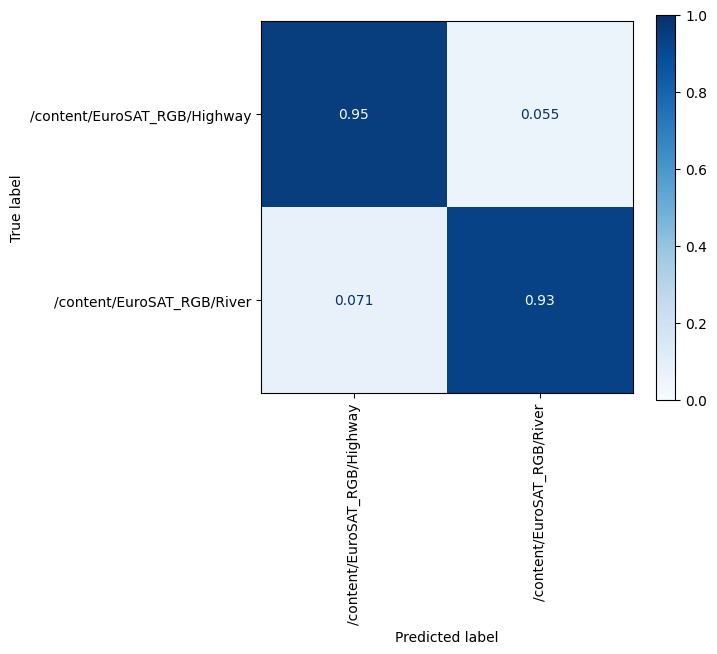

In [247]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))

cmd = ConfusionMatrixDisplay(cm, display_labels=handler.classes[:2])
cmd.plot(ax=axes, cmap='Blues', xticks_rotation='vertical')
print('S2')
print('Accuracy:', cm.diagonal(), 'mean: ', cm.diagonal().mean())
print(classification_report(targets, predictions, target_names=handler.classes[:2], digits=4))
axes.get_images()[0].set_clim(0, 1)
plt.show()
plt.close()